In [2]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import make_pipeline

import pickle

import warnings
warnings.filterwarnings("ignore")

In [3]:
import sqlite3

In [4]:
cnx = sqlite3.connect('database.sqlite')

In [5]:
dt = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", cnx)

In [6]:
print(dt)

                name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes


In [7]:
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)

In [8]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


Extracting Target column below

In [9]:
target = df.pop('overall_rating')

In [10]:
df.shape

(183978, 41)

In [11]:
target.head()

0    67.0
1    67.0
2    62.0
3    61.0
4    61.0
Name: overall_rating, dtype: float64

### Imputing target funtion :

In [12]:
target.isnull().values.sum()

836

there are 836 missing value present in target function.

In [13]:
target.describe()

count    183142.000000
mean         68.600015
std           7.041139
min          33.000000
25%          64.000000
50%          69.000000
75%          73.000000
max          94.000000
Name: overall_rating, dtype: float64

<IPython.core.display.Javascript object>


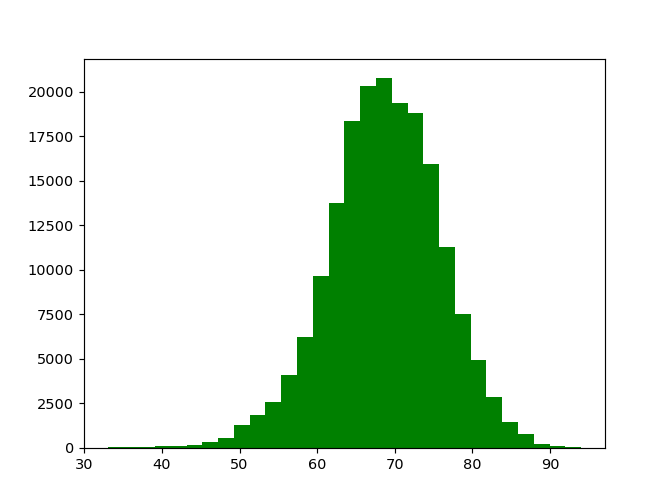

(array([7.0000e+00, 6.0000e+00, 2.0000e+01, 6.5000e+01, 9.4000e+01,
        1.4200e+02, 2.9400e+02, 5.2600e+02, 1.2510e+03, 1.8450e+03,
        2.5780e+03, 4.0870e+03, 6.1890e+03, 9.6500e+03, 1.3745e+04,
        1.8366e+04, 2.0310e+04, 2.0773e+04, 1.9382e+04, 1.8784e+04,
        1.5915e+04, 1.1254e+04, 7.5250e+03, 4.9470e+03, 2.8290e+03,
        1.4590e+03, 7.4800e+02, 2.2800e+02, 8.4000e+01, 3.9000e+01]),
 array([33.        , 35.03333333, 37.06666667, 39.1       , 41.13333333,
        43.16666667, 45.2       , 47.23333333, 49.26666667, 51.3       ,
        53.33333333, 55.36666667, 57.4       , 59.43333333, 61.46666667,
        63.5       , 65.53333333, 67.56666667, 69.6       , 71.63333333,
        73.66666667, 75.7       , 77.73333333, 79.76666667, 81.8       ,
        83.83333333, 85.86666667, 87.9       , 89.93333333, 91.96666667,
        94.        ]),
 <a list of 30 Patch objects>)

In [14]:
plt.hist(target, 30, range=(33, 94),color='green')

almost normal distribution so we can impute mean value for missing value in target.

In [15]:
y = target.fillna(target.mean())

In [16]:
y.isnull().values.any()

False

#  Data Exploration :

In [17]:
df.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'potential',
       'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
       'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'],
      dtype='object')

In [18]:
for col in df.columns:
    unique_cat = len(df[col].unique())
    print("{col}--> {unique_cat}..{typ}".format(col=col, unique_cat=unique_cat, typ=df[col].dtype))

id--> 183978..int64
player_fifa_api_id--> 11062..int64
player_api_id--> 11060..int64
date--> 197..object
potential--> 57..float64
preferred_foot--> 3..object
attacking_work_rate--> 9..object
defensive_work_rate--> 20..object
crossing--> 96..float64
finishing--> 98..float64
heading_accuracy--> 97..float64
short_passing--> 96..float64
volleys--> 94..float64
dribbling--> 98..float64
curve--> 93..float64
free_kick_accuracy--> 98..float64
long_passing--> 96..float64
ball_control--> 94..float64
acceleration--> 87..float64
sprint_speed--> 86..float64
agility--> 82..float64
reactions--> 79..float64
balance--> 82..float64
shot_power--> 97..float64
jumping--> 80..float64
stamina--> 85..float64
strength--> 83..float64
long_shots--> 97..float64
aggression--> 92..float64
interceptions--> 97..float64
positioning--> 96..float64
vision--> 98..float64
penalties--> 95..float64
marking--> 96..float64
standing_tackle--> 96..float64
sliding_tackle--> 95..float64
gk_diving--> 94..float64
gk_handling--> 91..

Doing One Hot encoding on object features except date feature

In [19]:
dummy_df = pd.get_dummies(df, columns=['preferred_foot', 'attacking_work_rate', 'defensive_work_rate'])
dummy_df.head()

,id,player_fifa_api_id,player_api_id,date,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,defensive_work_rate_9,defensive_work_rate__0,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky
0,1,218353,505942,2016-02-18 00:00:00,71.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
1,2,218353,505942,2015-11-19 00:00:00,71.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
2,3,218353,505942,2015-09-21 00:00:00,66.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
3,4,218353,505942,2015-03-20 00:00:00,65.0,48.0,43.0,70.0,60.0,43.0,...,0,0,0,0,0,0,1,0,0,0
4,5,218353,505942,2007-02-22 00:00:00,65.0,48.0,43.0,70.0,60.0,43.0,...,0,0,0,0,0,0,1,0,0,0


In [20]:
X = dummy_df.drop(['id', 'date'], axis=1)

### Feature selection :

As tree model doesn't gets affected by missing values present in data set. but feature selection by SelectFromModel can not be done on datasets that carries null value. Therefore, we should also perform imputation on dataset

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
#imputing null value of each column with the mean of that column
imput = Imputer()
X_train = imput.fit_transform(X_train)
X_test = imput.fit_transform(X_test)

In [23]:
#finding feature_importance for feature selection. from it we'll be able to decide threshold value
model = XGBRegressor()
model.fit(X_train, y_train)
print(model.feature_importances_)

[0.01714286 0.02       0.10714286 0.02       0.04714286 0.03571429
 0.03285714 0.         0.04       0.         0.         0.00714286
 0.04714286 0.01       0.01571429 0.00142857 0.18571429 0.
 0.01428571 0.00571429 0.00857143 0.03142857 0.00571429 0.00714286
 0.01857143 0.01857143 0.00571429 0.         0.04285714 0.04571429
 0.01       0.04571429 0.02571429 0.02428572 0.06       0.04285714
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


In [24]:
selection = SelectFromModel(model, threshold=0.01, prefit=True)

select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)

In [25]:
select_X_train.shape

(137983, 24)

### Training different models :

#### 1. Linear Regression

In [26]:
pipe = make_pipeline(StandardScaler(),             #preprocessing(standard scalling)
                     LinearRegression())           #estimator(linear regression)

cv = ShuffleSplit(random_state=0)   #defining type of cross_validation(shuffle spliting)

param_grid = {'linearregression__n_jobs': [-1]}     #parameters for model tunning

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

In [27]:
grid.fit(select_X_train, y_train)  

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size='default',
       train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'linearregression__n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [28]:
grid.best_params_

{'linearregression__n_jobs': -1}

In [29]:
lin_reg = pickle.dumps(grid)

#### Decision Tree

In [30]:
pipe = make_pipeline(StandardScaler(),                  #preprocessing
                     DecisionTreeRegressor(criterion='mse', random_state=0))          #estimator

cv = ShuffleSplit(n_splits=10, random_state=42)        #cross validation

param_grid = {'decisiontreeregressor__max_depth': [3, 5, 7, 9, 13]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

In [31]:
grid.fit(select_X_train, y_train)  

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size='default',
       train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('decisiontreeregressor', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'decisiontreeregressor__max_depth': [3, 5, 7, 9, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
grid.best_params_

{'decisiontreeregressor__max_depth': 13}

In [33]:
Dectree_reg = pickle.dumps(grid)

#### 3. Random Forest

In [34]:
pipe = make_pipeline(StandardScaler(),
                     RandomForestRegressor(n_estimators=500, random_state=123))

cv = ShuffleSplit(test_size=0.2, random_state=0)

param_grid = {'randomforestregressor__max_features':['sqrt', 'log2', 10],
              'randomforestregressor__max_depth':[9, 11, 13]}                 

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

In [35]:
grid.fit(select_X_train, y_train)   

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decr...imators=500, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestregressor__max_features': ['sqrt', 'log2', 10], 'randomforestregressor__max_depth': [9, 11, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
grid.best_params_

{'randomforestregressor__max_depth': 13,
 'randomforestregressor__max_features': 10}

In [37]:
Randfor_reg = pickle.dumps(grid)

#### 4. Xgboost regressor 

In [38]:
pipe = make_pipeline(StandardScaler(),
                     XGBRegressor(n_estimators= 500, random_state=42))

cv = ShuffleSplit(n_splits=10, random_state=0)

param_grid = {'xgbregressor__max_depth': [5, 7],
              'xgbregressor__learning_rate': [0.1, 0.3]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs= -1)

In [39]:
grid.fit(select_X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size='default',
       train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgbregressor', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, ...       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'xgbregressor__max_depth': [5, 7], 'xgbregressor__learning_rate': [0.1, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [40]:
grid.best_params_

{'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 7}

In [41]:
xgbreg = pickle.dumps(grid)

### Comparision between models

In [42]:
lin_reg = pickle.loads(lin_reg)
Dectree_reg = pickle.loads(Dectree_reg)
Randfor_reg = pickle.loads(Randfor_reg)
xgbreg = pickle.loads(xgbreg)

In [43]:
print("""Linear Regressor accuracy is {lin}
DecisionTree Regressor accuracy is {Dec}
RandomForest regressor accuracy is {ran}
XGBoost regressor accuracy is {xgb}""".format(lin=lin_reg.score(select_X_test, y_test),
                                                       Dec=Dectree_reg.score(select_X_test, y_test),
                                                       ran=Randfor_reg.score(select_X_test, y_test),
                                                       xgb=xgbreg.score(select_X_test, y_test)))

Linear Regressor accuracy is 0.8547439877398585
DecisionTree Regressor accuracy is 0.9300656646020649
RandomForest regressor accuracy is 0.9642395895691055
XGBoost regressor accuracy is 0.9824157032610178


By accuracy comparision performed above we can say hear that XGBoost regressor gives better result than any other model. and it can predict the target function with approx 98% accuracy.